In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xr
import intake

import matplotlib.pyplot as plt

import config
import gcp_gridfed_ff
import util

exists: /glade/scratch/mclong/tmp/regridding/latlon_0.1x0.1_lon0=-180.0.nc
exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc
source grid dims: (1800, 3600)
destination grid dims: (180, 360)


In [3]:
use_dask = True

if use_dask:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(12) #adapt(minimum_jobs=2, maximum_jobs=5)
    cluster

In [4]:
version = 'v2021.3'
yr1, yr2 = 1984, 2020

date_range = pd.date_range(start=f'{yr1:04d}-01-01', end=f'{yr2:04d}-12-31', freq='1Y')
date_range

DatetimeIndex(['1984-12-31', '1985-12-31', '1986-12-31', '1987-12-31',
               '1988-12-31', '1989-12-31', '1990-12-31', '1991-12-31',
               '1992-12-31', '1993-12-31', '1994-12-31', '1995-12-31',
               '1996-12-31', '1997-12-31', '1998-12-31', '1999-12-31',
               '2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31',
               '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31',
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31',
               '2020-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [5]:
if use_dask:
    ds_list = client.map(gcp_gridfed_ff.retrieve_datasets, date_range, version=version)
    ds_list = client.gather(ds_list)
else:
    ds_list = []
    for date in date_range:
        ds_list.append(gcp_gridfed_ff.retrieve_datasets(date, version=version))
               
ds = xr.concat(ds_list, dim='time', compat='override', coords='minimal').squeeze()
ds['area'] = ds_list[0].area
for v in ds.variables:
    ds[v].encoding = ds_list[0][v].encoding

ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 444, d2: 2)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time       (time) object 1984-01-16 12:00:00 ... 2020-12-16 12:00:00
Dimensions without coordinates: d2
Data variables:
    area       (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    SFCO2_FF   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SFO2_FF    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    time_bnds  (time, d2) object 1984-01-01 00:00:00 ... 2021-01-01 00:00:00
Attributes:
    description:  Emissions of CO2 from fossil fuel sources on a 0.1 x 0.1 gr...
    history:      Created by Matt Jones (UEA) on 2022-02-02; aggegrated and r...
    source:       GCP for total annual emissions at national level / EDGAR v4...

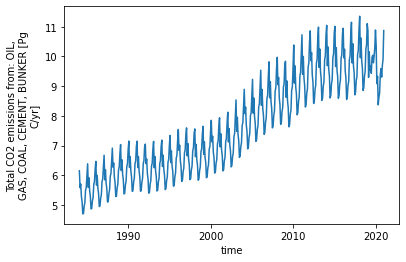

In [6]:
with xr.set_options(keep_attrs=True):
    sfco2_global = ds.SFCO2_FF.weighted(ds.area).sum(['lat', 'lon'])
    sfco2_global *= 12.01e-15 * 86400.0 * 365.0
sfco2_global.attrs['units'] = 'Pg C/yr'
sfco2_global.plot();

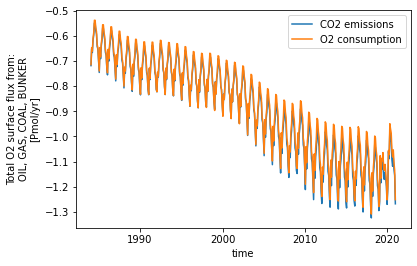

In [7]:
with xr.set_options(keep_attrs=True):
    sfo2_global = ds.SFO2_FF.weighted(ds.area).sum(['lat', 'lon'])
    sfo2_global *= 1e-15 * 86400.0 * 365.0
sfo2_global.attrs['units'] = 'Pmol/yr'

(sfco2_global / 12. * -1.4).plot(label='CO2 emissions');
sfo2_global.plot(label='O2 consumption');
plt.legend();

In [8]:
curator = util.curate_flux_products()

ds.attrs['source'] = 'https://zenodo.org/record/5956612'

file_out = f"{config.flux_product_dir}/SFCO2_FF.GCP-GridFED.{version}.{yr1:04d}0101-{yr2:04d}1231.nc"
util.to_netcdf_clean(ds[['SFCO2_FF', 'time_bnds', 'area']], file_out)
curator.add_source(
        key=f"SFCO2_FF.GCP-GridFED.{version}",
        urlpath=file_out,
        description='Gridded fossil CO2 emissions consistent with national inventories 1959-2020',
    )


file_out = f"{config.flux_product_dir}/SFO2_FF.GCP-GridFED.{version}.{yr1:04d}0101-{yr2:04d}1231.nc"
util.to_netcdf_clean(ds[['SFO2_FF', 'time_bnds', 'area']], file_out)                        
curator.add_source(
        key=f"SFO2_FF.GCP-GridFED.{version}",
        urlpath=file_out,
        description='Gridded fossil O2 combustion consistent with national inventories 1959-2020',
    )


------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/SFCO2_FF.GCP-GridFED.v2021.3.19840101-20201231.nc
netcdf SFCO2_FF.GCP-GridFED.v2021.3.19840101-20201231 {
dimensions:
	time = 444 ;
	lat = 180 ;
	lon = 360 ;
	d2 = 2 ;
variables:
	float SFCO2_FF(time, lat, lon) ;
		SFCO2_FF:_FillValue = 9.96921e+36f ;
		SFCO2_FF:units = "mol/m^2/s" ;
		SFCO2_FF:long_name = "Total CO2 emissions from: OIL, GAS, COAL, CEMENT, BUNKER" ;
	double time_bnds(time, d2) ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	double lat(lat) ;
	double lon(lon) ;
	double time(time) ;
		time:shift_time = 0. ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1984-01-01" ;
		time:calendar = "gregorian" ;

// global attributes:
		:description = "Emissions of CO2 from fossil fuel sources on a 0.1 x 0.1 grid. EDGAR v4.3.2 annual emissions are scaled at the national level to GCP emissions and subsequently amalgamated in thi

In [9]:
if use_dask:
    del client
    del cluster